In [1]:
!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

!unzip satellite-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  infl

In [2]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.4.1 Tensorflow Current Version: 2.17.0


In [3]:
from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

In [6]:
path = "/content/data/"

In [7]:
dir_path = "/content/data/"

In [8]:
img_list = get_image_paths(dir_path)

print(len(img_list))

5631


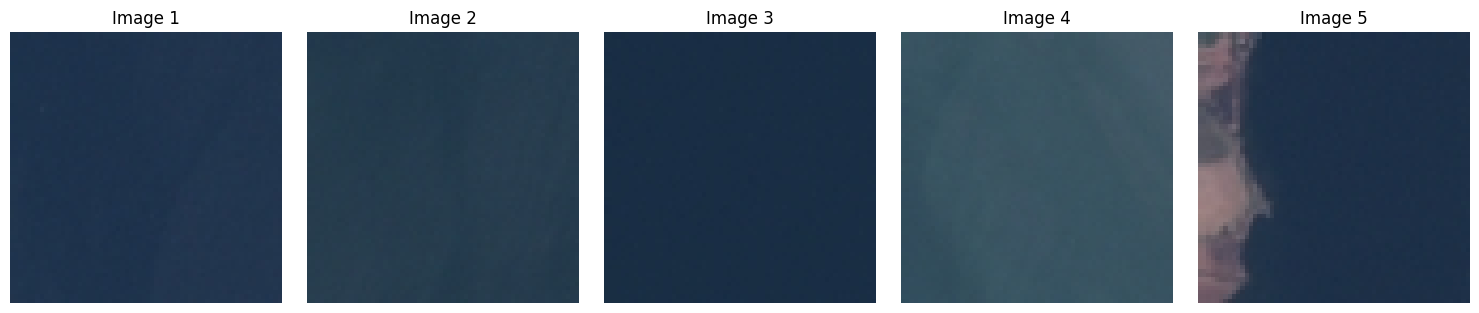

In [9]:
display_images(img_list[0:5])

In [10]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

In [11]:
train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=563,
                                        class_mode='categorical',
                                        subset='validation')

Found 5068 images belonging to 4 classes.
Found 563 images belonging to 4 classes.


In [12]:
from tensorflow.keras import layers, models, optimizers

# Modeli tanımla
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),  # Ekstra Convolutional Katman
    layers.GlobalAveragePooling2D(),  # Flatten yerine Global Average Pooling
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),  # Dropout oranını artırdık
    layers.Dense(4, activation='softmax'),
])

# Optimize edici, kayıp fonksiyonu ve metrikler
metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True)
]

# Daha düşük bir öğrenme oranı ile optimize edici
optimizer = optimizers.Adam(learning_rate=0.0001)  # Öğrenme oranını düşürdük

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=metrics)

# Erken durdurma ve model kontrol noktası
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,  # Sabırlılık süresini artırdık
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='satellite.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)

In [13]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.4367 - auc: 0.7922 - loss: 1.1072
Epoch 1: val_loss improved from inf to 0.52476, saving model to satellite.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 95s 518ms/step - accuracy: 0.4375 - auc: 0.7927 - loss: 1.1056 - val_accuracy: 0.8135 - val_auc: 0.9525 - val_loss: 0.5248
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6996 - auc: 0.9123 - loss: 0.5353
Epoch 2: val_loss improved from 0.52476 to 0.49272, saving model to satellite.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 108s 360ms/step - accuracy: 0.6996 - auc: 0.9123 - loss: 0.5353 - val_accuracy: 0.7904 - val_auc: 0.9627 - val_loss: 0.4927
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7605 - auc: 0.9354 - loss: 0.4750
Epoch 3: val_loss improved from 0.49272 to 0.44073, saving model to satellite.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 357ms/step - accuracy: 0.7605 - auc: 0.9354 - loss: 0.4750 - val_accuracy: 0.8277 - val_auc: 0.9635 - val_loss: 0.4407


In [14]:
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 0.24582646787166595
Accuracy: 0.9200710654258728
AUC: 0.9856643676757812


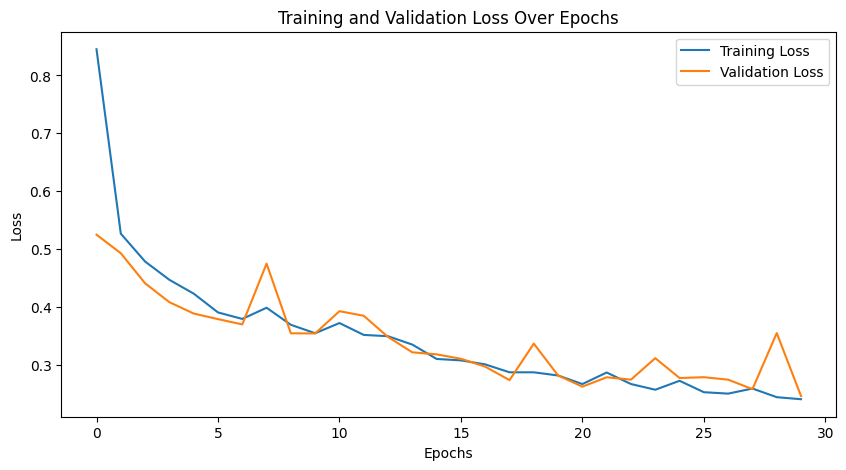

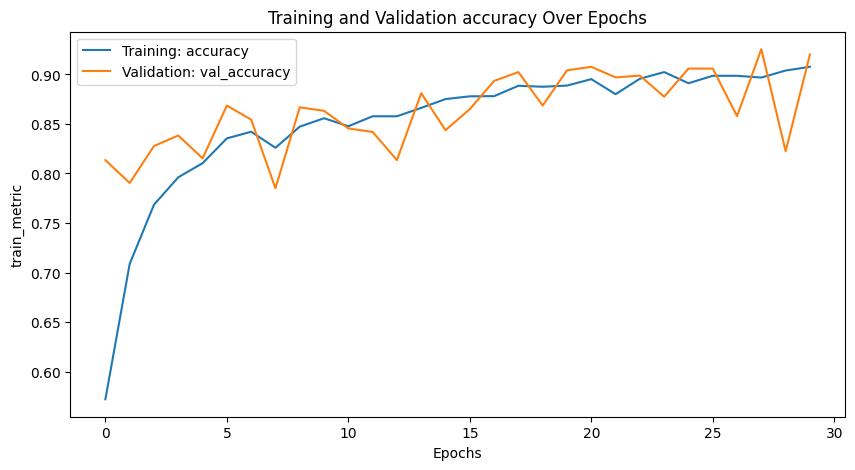

In [15]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

In [16]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.nasnet import NASNetMobile, preprocess_input as preprocess_input_nasnet

In [17]:
base_model = NASNetMobile(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
base_model.summary()

Model: "nasnet_mobile"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activat

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 4,232,978 (16.15 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [19]:
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [20]:
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(4, activation='softmax')(x)

fine_tuning_model = Model(inputs=base_model.input, outputs=x)

optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

fine_tuning_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

In [21]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)


model_checkpoint = ModelCheckpoint('NASNetMobile_finetuned.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   verbose=1)

In [22]:
start_time = datetime.datetime.now()

fine_tuning_model_history = fine_tuning_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.3261 - loss: 1.3895
Epoch 1: val_loss improved from inf to 1.15529, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 163s 798ms/step - accuracy: 0.3269 - loss: 1.3887 - val_accuracy: 0.5933 - val_loss: 1.1553
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7128 - loss: 1.0111
Epoch 2: val_loss improved from 1.15529 to 0.96778, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 122s 387ms/step - accuracy: 0.7128 - loss: 1.0109 - val_accuracy: 0.6519 - val_loss: 0.9678
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7493 - loss: 0.8528
Epoch 3: val_loss improved from 0.96778 to 0.84848, saving model to NASNetMobile_finetuned.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.7494 - loss: 0.8526 - val_accuracy: 0.6945 - val_loss: 0.8485
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7855 - loss: 0.7335

In [23]:
val_loss, val_accuracy = fine_tuning_model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")

Loss: 0.24638670682907104
Accuracy: 0.950266420841217


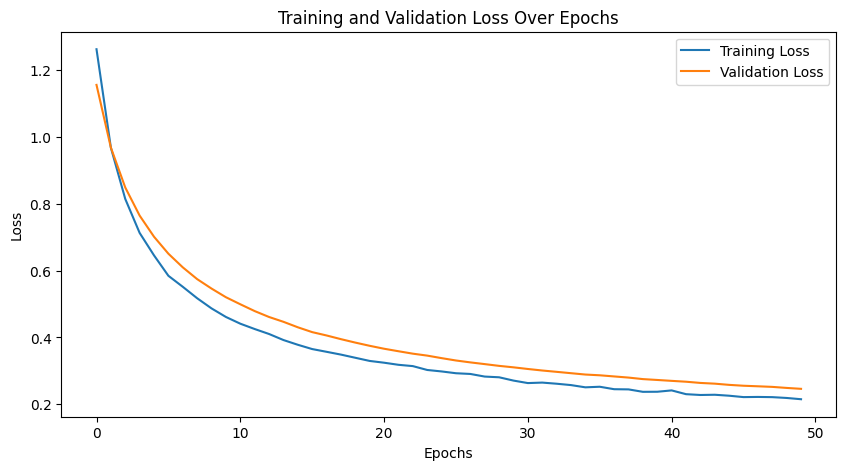

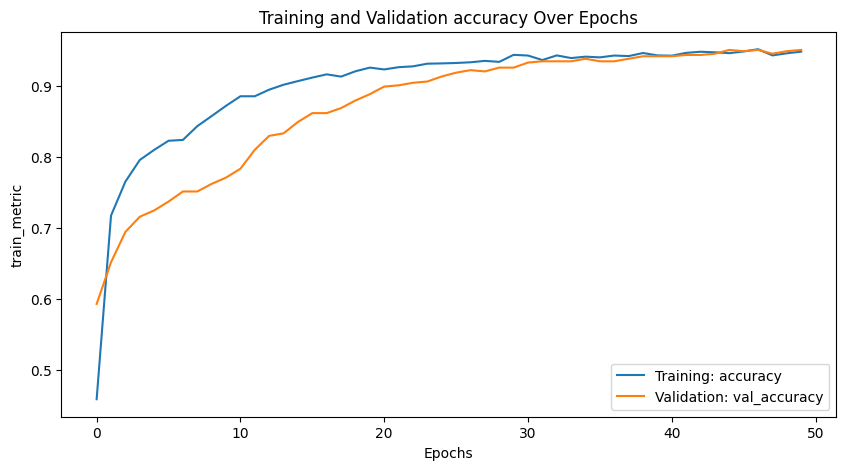

In [24]:
plot_training_history(fine_tuning_model_history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')